In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from functools import partial


In [2]:
# Constants
NUM_ARMS = 10       # Number of arms in the bandit
NUM_RUNS = 2000     # Number of independent runs
NUM_STEPS = 1000    # Number of time steps per run


In [3]:
class TenArmedBandit:
    """
    Ten-armed bandit environment.
    """
    def __init__(self):
        # True action values drawn from a normal distribution
        self.q_true = np.random.randn(NUM_ARMS)
        # Optimal action is the one with the highest true value
        self.optimal_action = np.argmax(self.q_true)
    
    def step(self, action):
        """
        Generate a reward for the selected action.
        Reward is drawn from a normal distribution centered at q_true[action].
        """
        reward = self.q_true[action] + np.random.randn()
        return reward


In [4]:
class EpsilonGreedyAgent:
    """
    Epsilon-greedy agent.
    """
    def __init__(self, epsilon=0.0):
        """
        Initialize the agent.
        
        Parameters:
        - epsilon: Exploration rate.
        """
        self.epsilon = epsilon
        # Estimated action values initialized to zero
        self.Q = np.zeros(NUM_ARMS)
        # Action counts initialized to zero
        self.N = np.zeros(NUM_ARMS)
    
    def select_action(self):
        """
        Select an action using the epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            action = np.random.randint(NUM_ARMS)
        else:
            # Exploit: choose the best current action
            action = np.argmax(self.Q)
        return action
    
    def update(self, action, reward):
        """
        Update the estimated value of the selected action using sample-average method.
        """
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]


In [5]:
def single_run(epsilons, max_steps, seed=None):
    """
    Perform a single run for multiple agents with different epsilon values.
    
    Returns:
    - received_rewards: Array of rewards received by each agent at each time step.
    - is_action_optimal: Array indicating whether the optimal action was selected.
    """
    if seed is not None:
        np.random.seed(seed)
    
    num_agents = len(epsilons)
    received_rewards = np.zeros((num_agents, max_steps))
    is_action_optimal = np.zeros_like(received_rewards)
    
    # For each agent with a different epsilon
    for i, epsilon in enumerate(epsilons):
        # Initialize environment and agent
        env = TenArmedBandit()
        agent = EpsilonGreedyAgent(epsilon=epsilon)
        # Run the steps
        for step in range(max_steps):
            action = agent.select_action()
            reward = env.step(action)
            agent.update(action, reward)
            received_rewards[i, step] = reward
            # Check if the selected action is optimal
            if action == env.optimal_action:
                is_action_optimal[i, step] = 1
    return received_rewards, is_action_optimal


Running simulations...


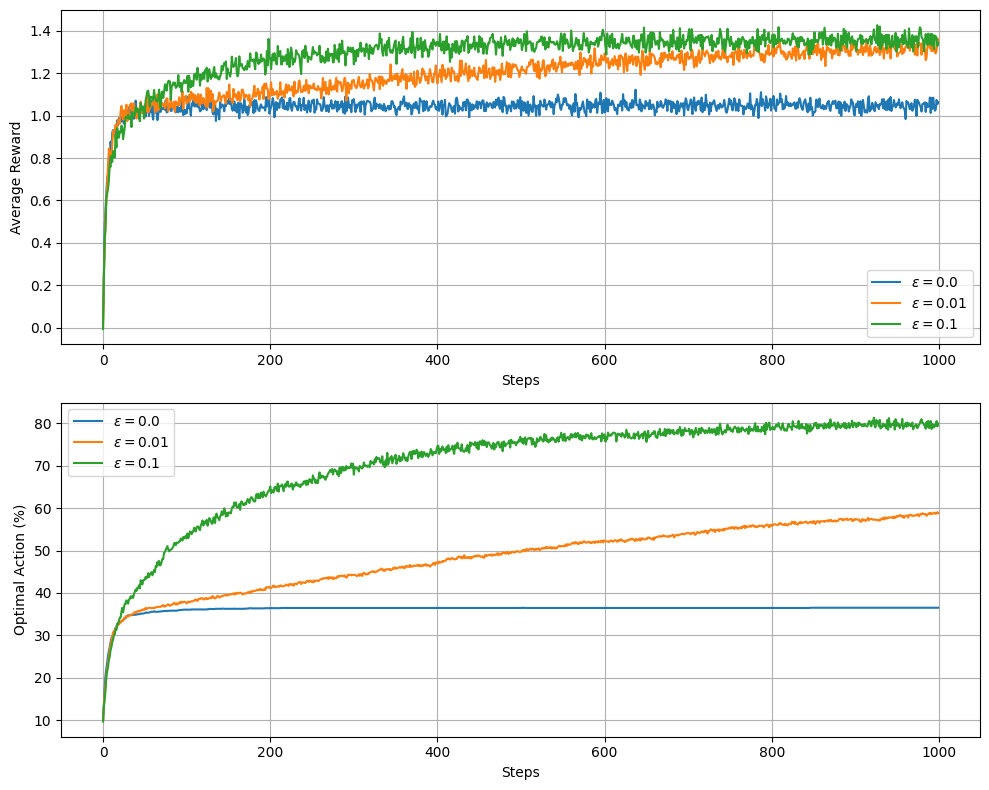

In [6]:
def main():
    """
    Main function to run simulations and plot the results.
    """
    # Exploration rates to test
    epsilons = [0.0, 0.01, 0.1]
    
    # Generate random seeds for reproducibility
    seeds = np.random.randint(0, 1000000, size=NUM_RUNS)
    
    # Partial function with fixed parameters
    single_run_partial = partial(single_run, epsilons=epsilons, max_steps=NUM_STEPS)
    
    # Run simulations in parallel
    print("Running simulations...")
    results = Parallel(n_jobs=-1)(
        delayed(single_run_partial)(seed=seed) for seed in seeds
    )
    
    # Extract results
    received_rewards = np.array([result[0] for result in results])  # Shape: (NUM_RUNS, num_agents, NUM_STEPS)
    is_action_optimal = np.array([result[1] for result in results]) # Shape: (NUM_RUNS, num_agents, NUM_STEPS)
    
    # Compute averages over runs
    averaged_received_rewards = np.mean(received_rewards, axis=0)    # Shape: (num_agents, NUM_STEPS)
    averaged_is_action_optimal = np.mean(is_action_optimal, axis=0) * 100  # Percentage
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    
    # Plot average rewards
    plt.subplot(2, 1, 1)
    for i, epsilon in enumerate(epsilons):
        plt.plot(averaged_received_rewards[i], label=f'$\epsilon = {epsilon}$')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    
    # Plot optimal action percentages
    plt.subplot(2, 1, 2)
    for i, epsilon in enumerate(epsilons):
        plt.plot(averaged_is_action_optimal[i], label=f'$\epsilon = {epsilon}$')
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()